<function matplotlib.pyplot.imshow(X: 'ArrayLike | PIL.Image.Image', cmap: 'str | Colormap | None' = None, norm: 'str | Normalize | None' = None, *, aspect: "Literal['equal', 'auto'] | float | None" = None, interpolation: 'str | None' = None, alpha: 'float | ArrayLike | None' = None, vmin: 'float | None' = None, vmax: 'float | None' = None, colorizer: 'Colorizer | None' = None, origin: "Literal['upper', 'lower'] | None" = None, extent: 'tuple[float, float, float, float] | None' = None, interpolation_stage: "Literal['data', 'rgba', 'auto'] | None" = None, filternorm: 'bool' = True, filterrad: 'float' = 4.0, resample: 'bool | None' = None, url: 'str | None' = None, data=None, **kwargs) -> 'AxesImage'>

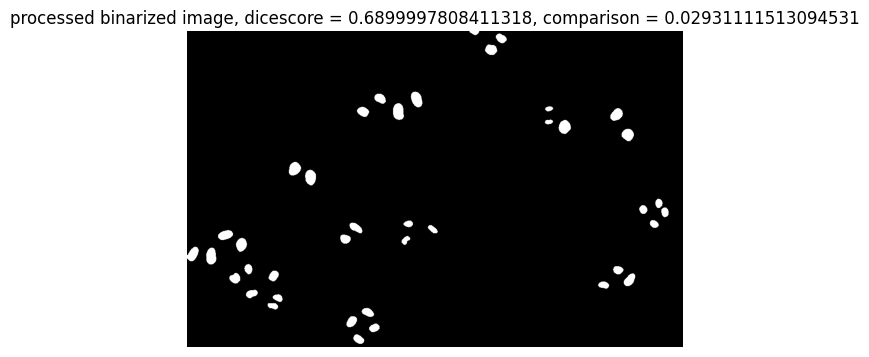

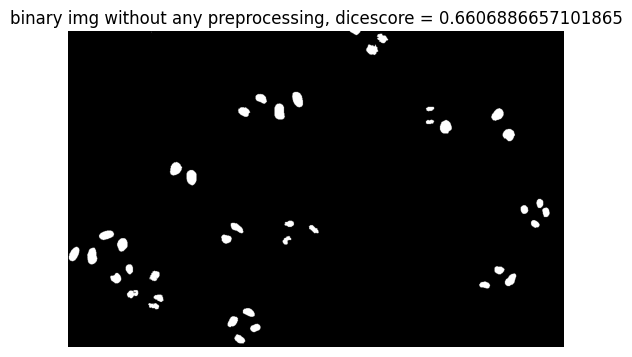

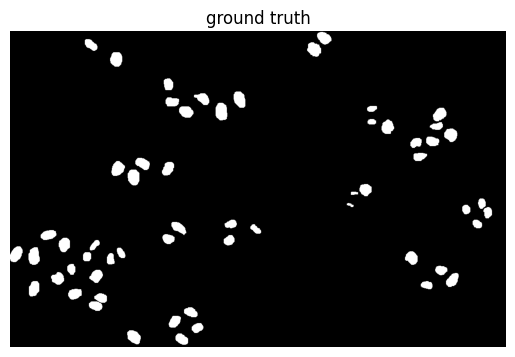

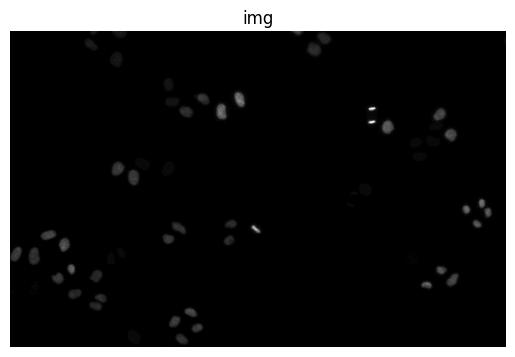

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.filters import threshold_otsu

# reads image
image = "data/N2DL-HeLa/img/t13.tif"
img = imread(image, as_gray=True)

groundtruth = "data/N2DL-HeLa/gt/man_seg13.tif"

gt = imread(groundtruth, as_gray=True)

gt_boolean = gt == 0

gt = 1 - gt_boolean

# Compute Mode
def mode_of_image(image, bins=256):
    """
    Calculates the highest mode of the gray level histogram.

    Parameters:
    - image: 2D numpy array of the grayscale image.
    - number of bins for histogram computation

    Returns:
    The intensity value which has the highest frequency within in the image.
    """

    # Calculate histogram
    hist, bin_edges = np.histogram(image, bins=bins, range=(0, 1))
    
    # Determine the index of the highest bin
    max_index = np.argmax(hist)

    # Calculate the center of the max bin
    bin_center = (bin_edges[max_index] + bin_edges[max_index + 1]) / 2

    return bin_center

# Wiener filter
def local_wiener_filter(image, window_size=5, noise_variance=None):
    """
    Apply a local adaptive Wiener filter to a grayscale image.

    Parameters:
    - image: 2D numpy array of the grayscale image.
    - window_size: size of the square window (odd integer).
    - noise_variance: estimated variance of the noise; if None, estimate globally.

    Returns:
    - filtered: the Wiener-filtered image as a 2D numpy array.
    """
    # Pad the image to handle borders
    pad = window_size // 2
    img_padded = np.pad(image, pad, mode='reflect')

    # Estimate global noise variance if not provided
    if noise_variance is None:
        noise_variance = np.var(image - np.mean(image))

    filtered = np.zeros_like(image)
    # Slide window over image
    for i in range(filtered.shape[0]):
        for j in range(filtered.shape[1]):
            window = img_padded[i:i+window_size, j:j+window_size]
            local_mean = window.mean()
            local_var = window.var()
            # Compute Wiener filter response
            if local_var > noise_variance:
                filtered[i, j] = local_mean + (local_var - noise_variance) / local_var * (image[i, j] - local_mean)
            else:
                filtered[i, j] = local_mean

    f = filtered
    f_norm = (f - f.min()) / (f.max() - f.min())
    filtered = f_norm
    return filtered

# Gamma transformation
def gammatransformation(image):
   """
    Every pixel value p is transformed by p^gamma.

    Parameters
    ----------
    parameter1 : gray level image
        A 2D array containing all the gray levels of each pixel.

    Returns 
    -------
    new image as 2D array.
       Each pixel value of the transformed image is result of p^gamma.
       Result is in the range 0-1
    """
   
   if np.max(image) != 1:
      image = image/np.max(image)  
  
   gamma = 10

   img_gamma = np.power(image, gamma)

   return img_gamma

# Histogram equalization
def histogramequalization(image):
   """
    Spreads the intensity values to the full range of 0-255.

    Parameters
    ----------
    parameter1 : gray level image
        A 2D array containing all the gray levels of each pixel.

    Returns 
    -------
    new image as 2D array.
       New image uses the full range of 0-255
    """
   if np.max(image) == 255:
      image_8bit = (image).astype(np.uint8)
   else:
      image_8bit = (image/np.max(image) * 255).astype(np.uint8)

   hist, bins = np.histogram(image_8bit.flatten(), bins=256, range=[0, 256])
  
   cdf = hist.cumsum()
  
   cdf_normalized = cdf * 255 / cdf[-1] 

   image_eq = cdf_normalized[image_8bit]

   image_eq = image_eq.astype(np.uint8)

   return image_eq

# Mean filter
def mean_filter(image, kernel_size = 9) -> np.ndarray:
    """
    Apply a mean filter (box blur) to a 2D grayscale image using only NumPy.

    Parameters
    ----------
    image : np.ndarray
        2D array of the grayscale image.
    kernel_size : int
        Size of the (square) kernel; must be odd.

    Returns
    -------
    filtered : np.ndarray
        The blurred image, same shape as input.
    """
    if kernel_size % 2 == 0:
        raise ValueError("kernel_size must be odd.")
    pad = kernel_size // 2
    # Spiegele die Ränder, damit wir auch am Rand filtern können
    img_padded = np.pad(image, pad, mode='reflect')
    H, W = image.shape
    filtered = np.empty_like(image, dtype=float)

    # Summen-Integralbild zur schnellen Fenster-Summen
    # Integralbild hat eine zusätzliche Null-Zeile/-Spalte vorne
    integral = np.cumsum(np.cumsum(img_padded, axis=0), axis=1)
    # Schleife über alle Pixel
    for i in range(H):
     for j in range(W):
      window = img_padded[i:i+kernel_size, j:j+kernel_size]
      filtered[i,j] = window.sum() / (kernel_size**2)
    return filtered

# Otsu thresholding
def otsu_threshold(img: np.ndarray) -> int:
    """
    Globaler Otsu-Schwellenwert für ein 8-Bit-Bild (0–255).
    """
    # Scale to 8 bit image (0-255)
    if np.max(img) != 255:
       img = (img * 255.0 / np.max(img)).astype(np.uint8)

    # Histogramm der absoluten Häufigkeiten
    hist, _ = np.histogram(img.ravel(), bins=256, range=(0, 256))

    prob = hist.astype(float) / hist.sum()   # p(k)
    P = np.cumsum(prob)                      # ω(k)
    k = np.arange(256)                     # Grauwert-Indizes
    mu = np.cumsum(k * prob)                 # μ(k)
    mu_T = mu[-1]

    # Between-class variance σ_b²(k)
    sigma_b2 = (mu_T * P - mu)**2 / (P * (1.0 - P) + 1e-12)

    return int(np.nanargmax(sigma_b2))       # höchstes σ_b² → Schwelle


# Dice score
def dice_score(otsu_img, otsu_gt):

    # control if the Pictures have the same Size
    if len(otsu_img) != len(otsu_gt):
       if len(otsu_img) > len(otsu_gt):
         otsu_img = otsu_img[1:len(otsu_gt)]
       else:
        otsu_gt = otsu_gt[1:len(otsu_img)]


    # defining the variables for the Dice Score equation
    positive_overlap = 0
    sum_img = 0
    sum_gt = 0

    for t, p in zip(otsu_img, otsu_gt):
        if t == 1:
            sum_img += 1
        if p == 1:
            sum_gt += 1
        if t == 1 and p == 1:
            positive_overlap += 1

    if sum_img + sum_gt == 0:
        return 1.0

    return 2 * positive_overlap / (sum_img + sum_gt)



# Application of Wiener_filter, Gamma_transformation, Histogram_equalization, Otsu, Meanfilter, 2nd Otsu

# Wienerfilter, background estimation and removal
bg = local_wiener_filter(img, window_size=10)

img_filtered = img - bg

# Gamma transformation
img_filtered_gamma = gammatransformation(img_filtered)



# Otsu thresholding of eq image
T = threshold_otsu(img_filtered_gamma)

binary_eq = (img_filtered_gamma > T).astype(np.uint8)

# Mean filter of eq image
binary_meanfiltered_eq = mean_filter(binary_eq, kernel_size=7)

# Scale to 8 bit image (0-255)
binary_meanfiltered_eq = (binary_meanfiltered_eq * 255.0 / np.max(binary_meanfiltered_eq)).astype(np.uint8)

# 2nd Otsu thresholding of eq image
T = threshold_otsu(binary_meanfiltered_eq)

binary = (binary_meanfiltered_eq > T).astype(np.uint8)



# Otsu thresholding on OG
# Scale to 8 bit image (0-255)
if np.max(img) != 255:
     img = (img * 255.0 / np.max(img)).astype(np.uint8)
T = otsu_threshold(img)
binary_img = (img > T).astype(np.uint8)


# Compute dice score
binary_flatten = binary.flatten()

binary_img_flatten = binary_img.flatten()

gt_flattten = gt.flatten()

dice_score_binary = dice_score(binary_flatten, gt_flattten)

dice_score_binary_img = dice_score(binary_img_flatten, gt_flattten)

a = dice_score_binary - dice_score_binary_img


# Display image
plt.figure()
plt.imshow(binary, cmap='gray')
plt.title(f'processed binarized image, dicescore = {dice_score_binary}, comparison = {a}')
plt.axis('off')
plt.imshow



plt.figure()
plt.imshow(binary_img, cmap='gray')
plt.title(f'binary img without any preprocessing, dicescore = {dice_score_binary_img}')
plt.axis('off')
plt.imshow

plt.figure()
plt.imshow(gt, cmap='gray')
plt.title("ground truth")
plt.axis('off')
plt.imshow



plt.figure()
plt.imshow(img, cmap='gray')
plt.title("img")
plt.axis('off')
plt.imshow



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.image import imread
from pathlib import Path
from PIL import Image
from typing import Union, Tuple

#------ALL FUNCTIONS NEEDED------

# Compute Mode
def mode_of_image(image, bins=256):
    """
    Calculates the highest mode of the gray level histogram.

    Parameters:
    - image: 2D numpy array of the grayscale image.
    - number of bins for histogram computation

    Returns:
    The intensity value which has the highest frequency within in the image.
    """

    # Calculate histogram
    hist, bin_edges = np.histogram(image, bins=bins, range=(0, 1))
    
    # Determine the index of the highest bin
    max_index = np.argmax(hist)

    # Calculate the center of the max bin
    bin_center = (bin_edges[max_index] + bin_edges[max_index + 1]) / 2

    return bin_center

# Wiener filter
def local_wiener_filter(image, window_size=5, noise_variance=None):
    """
    Apply a local adaptive Wiener filter to a grayscale image.

    Parameters:
    - image: 2D numpy array of the grayscale image.
    - window_size: size of the square window (odd integer).
    - noise_variance: estimated variance of the noise; if None, estimate globally.

    Returns:
    - filtered: the Wiener-filtered image as a 2D numpy array.
    """
    # Pad the image to handle borders
    pad = window_size // 2
    img_padded = np.pad(image, pad, mode='reflect')

    # Estimate global noise variance if not provided
    if noise_variance is None:
        noise_variance = np.var(image - np.mean(image))

    filtered = np.zeros_like(image)
    # Slide window over image
    for i in range(filtered.shape[0]):
        for j in range(filtered.shape[1]):
            window = img_padded[i:i+window_size, j:j+window_size]
            local_mean = window.mean()
            local_var = window.var()
            # Compute Wiener filter response
            if local_var > noise_variance:
                filtered[i, j] = local_mean + (local_var - noise_variance) / local_var * (image[i, j] - local_mean)
            else:
                filtered[i, j] = local_mean

    f = filtered
    f_norm = (f - f.min()) / (f.max() - f.min())
    filtered = f_norm
    return filtered

# Gamma transformation
def gammatransformation(image):
   """
    Every pixel value p is transformed by p^gamma.

    Parameters
    ----------
    parameter1 : gray level image
        A 2D array containing all the gray levels of each pixel.

    Returns 
    -------
    new image as 2D array.
       Each pixel value of the transformed image is result of p^gamma.
       Result is in the range 0-1
    """
   
   if np.max(image) != 1:
      image = image/np.max(image)  
  
   gamma = 2

   img_gamma = np.power(image, gamma)

   return img_gamma

# Histogram equalization
def histogramequalization(image):
   """
    Spreads the intensity values to the full range of 0-255.

    Parameters
    ----------
    parameter1 : gray level image
        A 2D array containing all the gray levels of each pixel.

    Returns 
    -------
    new image as 2D array.
       New image uses the full range of 0-255
    """
   if np.max(image) == 255:
      image_8bit = (image).astype(np.uint8)
   else:
      image_8bit = (image/np.max(image) * 255).astype(np.uint8)

   hist, bins = np.histogram(image_8bit.flatten(), bins=256, range=[0, 256])
  
   cdf = hist.cumsum()
  
   cdf_normalized = cdf * 255 / cdf[-1] 

   image_eq = cdf_normalized[image_8bit]

   image_eq = image_eq.astype(np.uint8)

   return image_eq

# Mean filter
def mean_filter(image, kernel_size = 3) -> np.ndarray:
    """
    Apply a mean filter (box blur) to a 2D grayscale image using only NumPy.

    Parameters
    ----------
    image : np.ndarray
        2D array of the grayscale image.
    kernel_size : int
        Size of the (square) kernel; must be odd.

    Returns
    -------
    filtered : np.ndarray
        The blurred image, same shape as input.
    """
    if kernel_size % 2 == 0:
        raise ValueError("kernel_size must be odd.")
    pad = kernel_size // 2
    # Spiegele die Ränder, damit wir auch am Rand filtern können
    img_padded = np.pad(image, pad, mode='reflect')
    H, W = image.shape
    filtered = np.empty_like(image, dtype=float)

    # Summen-Integralbild zur schnellen Fenster-Summen
    # Integralbild hat eine zusätzliche Null-Zeile/-Spalte vorne
    integral = np.cumsum(np.cumsum(img_padded, axis=0), axis=1)
    # Schleife über alle Pixel
    for i in range(H):
     for j in range(W):
      window = img_padded[i:i+kernel_size, j:j+kernel_size]
      filtered[i,j] = window.sum() / (kernel_size**2)
    return filtered

# Compute histogram
def compute_gray_histogram(
    image_source: Union[Path, str, np.ndarray],
    bins: int = 256,
    value_range: Tuple[int, int] = (0, 255)
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Liest ein Bild ein (Pfad oder NumPy-Array), wandelt in Graustufen um und
    berechnet das Histogramm.

    Args:
        image_source: Pfad (Path/str) zum Bild ODER ein 2D-NumPy-Array mit Grauwerten.
        bins: Anzahl der Bins für das Histogramm.
        value_range: Wertebereich (min, max).

    Returns:
        hist: Array der Pixelhäufigkeiten pro Bin.
        bin_edges: Randwerte der Bins.
    """
    # 1) Input erkennen und in Grauwert-Array umwandeln
    if isinstance(image_source, (Path, str)):
        img = Image.open(str(image_source)).convert("L")
        arr = np.array(img)
    elif isinstance(image_source, np.ndarray):
        arr = image_source
    else:
        raise TypeError(
            "compute_gray_histogram erwartet einen Pfad (Path/str) oder ein NumPy-Array."
        )

    # 2) Histogramm berechnen
    hist, bin_edges = np.histogram(
        arr.ravel(),
        bins=bins,
        range=value_range
    )
    return hist, bin_edges

# Otsu thresholding
def otsu_threshold(p: np.ndarray) -> int:
    """
    Berechnet den globalen Otsu-Schwellenwert aus Wahrscheinlichkeiten p[k].
    """
    P = np.cumsum(p)                    # kumulative Wahrscheinlichkeiten
    bins = np.arange(len(p))            # mögliche Grauwert-Indizes
    mu = np.cumsum(bins * p)            # kumuliertes gewichtetes Mittel
    mu_T = mu[-1]                       # Gesamtmittel
    # Interklassenvarianz mit Epsilon für Stabilität
    sigma_b2 = (mu_T * P - mu)**2 / (P * (1 - P) + 1e-12)
    return int(np.argmax(sigma_b2))

# Bianrization after thresholding
def binarize(arr: np.ndarray, t: int) -> np.ndarray:
    """
    Wendet den Schwellenwert t an und gibt ein binäres 0/1-Array zurück.
    """
    return (arr > t).astype(np.uint8)

# Hist computation plus Otsu
def apply_global_otsu(image: np.ndarray) -> np.ndarray:
    """
    Vollständige Pipeline:
    - Histogramm berechnen
    - Wahrscheinlichkeiten p[k] bilden
    - Otsu-Schwellenwert berechnen
    - Binarisierung durchführen

    Returns ein 2D-Binär-Array (0/1).
    """
    hist, _ = compute_gray_histogram(image)
    p = hist / hist.sum()
    t = otsu_threshold(p)
    return binarize(image, t)

# Dice score
def dice_score(otsu_img, otsu_gt):

    # control if the Pictures have the same Size
    if len(otsu_img) != len(otsu_gt):
       if len(otsu_img) > len(otsu_gt):
         otsu_img = otsu_img[1:len(otsu_gt)]
       else:
        otsu_gt = otsu_gt[1:len(otsu_img)]


    # defining the variables for the Dice Score equation
    positive_overlap = 0
    sum_img = 0
    sum_gt = 0

    for t, p in zip(otsu_img, otsu_gt):
        if t == 1:
            sum_img += 1
        if p == 1:
            sum_gt += 1
        if t == 1 and p == 1:
            positive_overlap += 1

    if sum_img + sum_gt == 0:
        return 1.0

    return 2 * positive_overlap / (sum_img + sum_gt)

# Process single image and its groundtruth
def process_single(img_path: Path, gt_path: Path) -> float:
    """ 
    Reads one image and corresponding groundtruth, proccesses, segments and computes dice score for one image.
    """
    # Reads image and reads, binarizes groundtruth
    img = imread(img_path)
    if np.ndim(img) >= 3:
      img = img[..., 0]  
    img_scaled  = (img / img.max() * 255).astype(np.uint8)

    gt = imread(gt_path)
    if np.ndim(gt) >= 3:
       gt = gt[..., 0]
    gt  = 1 - ((gt / gt.max() * 255).astype(np.uint8) == 0)         

    # Wiener filter, background estimation and removal
    bg  = local_wiener_filter(img_scaled, window_size=10)
    img_filtered = img_scaled - bg

    # Gamma transformation
    img_gamma = gammatransformation(img_filtered)

    # Hist-Equalization
    img_eq = histogramequalization(img_gamma)

    # 1nd Otsu-thresholding + Meanfilter + 2nd Otsu thresholding 
    
    # 1nd Otsu
    binary1 = apply_global_otsu(img_eq)

    # Mean filter
    binary1_meanfiltered = mean_filter(binary1, kernel_size=7)

    # Scale to 8 bit image (0-255)
    binary1_meanfiltered = (binary1_meanfiltered * 255.0 / np.max(binary1_meanfiltered)).astype(np.uint8)

    # 2nd Otsu
    binary2 = apply_global_otsu(binary1_meanfiltered)

    # Invert if necessary
    if mode_of_image(binary2) > .5:            
        binary2 = 1 - binary2

    # 5. Compute Dice score
    return dice_score(binary2.flatten(), gt.flatten())

# -------------------------------------------------------------------
# Mainroutine: Going through all image-gt pairs and collect all dice scores of data set: NIH3T3
# -------------------------------------------------------------------
img_dir = Path("data/NIH3T3/img")
gt_dir  = Path("data/NIH3T3/gt")

dice_scores = []

for img_file in sorted(img_dir.glob("dna-*.png")):
    # Extract index to read the corresponding gt
    idx = img_file.stem.split('-')[-1]
    gt_file = gt_dir / f"{idx}.png"

    if not gt_file.exists():
        print(f" ! Kein Ground-Truth für {img_file.name} ! überspringe …")
        continue

    score = process_single(img_file, gt_file)
    dice_scores.append(score)
    print(f"{img_file.name:<20} Dice = {score:.4f}")

# Vector containing all dice scores
dice_scores = np.array(dice_scores)           
print("\nDONE ⇢ Mean Dice:", dice_scores.mean())


dna-0.png            Dice = 0.5516
dna-1.png            Dice = 0.0000


KeyboardInterrupt: 